# COGS 118A- Project Checkpoint

# Names

Hopefully your team is at least this good. Obviously you should replace these with your names.

- William Wei
- Charmie Donasco
- Rizq Khateeb
- Michael Lai
- Siu Wu

# Abstract 
The goal of this project is to classify and differentiate between the chest X-ray images of COVID-19 positive cases, normal lungs, and Lung Opacity (Non-COVID lung infection). The data consists of images of X-rays and lung masks and will be measured by cutting the three classes down to 3600 images each (3600 Positive COVID-19, 3600 Normal Lungs, 3600 Lung Opacity (Non-COVID lung infection)) and compare each and see if there is more than a 33% match rate. We will be using CNN (convolutional neural network) to process the pixel data in the image to pick up on the differences in the images of the X-rays.

# Background

In recent years, image classification becomes more and more popular as they can extract characteristics from the images and then identify the correct the categories those images should belong to<a name="DluQweng"></a>[<sup>[1]</sup>](#DluQwengnote). This is beneficial and effective in the way that it saves a lot of time and effort when trying to categorize daramatic amount of images manually. There are lot of paper going over and reviewing the major techniques in the field of image classification and discussing over how to improve the performance. In related to our project, we have looked at papers which introduces the deep learning paradigm of Convolutional neual network(CNN). The paper discusses in detail about the development of CNN and its main features. The paper also introduces the potential limitations and applications of method of CNN<a name="Alzubaidi"></a>[<sup>[2]</sup>](#Alzubaidinote). We believe that the ability to identify the COVID-affected, normal and ohter lung infection patients based on the chest X-ray images would be meaningful and helpful since the pandemic still goes on.

# Problem Statement

The main problem this project will solve is diagnosis of lung conditions in patients. The x-ray images have key features that highlight the likely condition and indicate the diagnosis the patient should receive, but our project will use convolutional neural networks and train a model to ultimately classify whether the patient is healthy, afflicted with pneumonia, or has COVID automatically.

# Data

Link to the dataset: 
https://www.kaggle.com/tawsifurrahman/covid19-radiography-database

This data set contains 19820 imagnes of COVID-19 chest x-rays and lung masks each photo a png image with the diamentions of 299 by 299 pixels. The chest x-rays are images which showcase a scan of the entire chest area and the lung mask, which is provided by the dataset, is an additional black and white mask used to mask out everything in the chest x-rays besides the lungs. This is important as we want our model to primary focus on the lung portion of the X-ray and not to take in excess factors when classifying. Image of the X-ray and lung mask can be seen below.


<img src="images/example1.png">
<br> <img src="images/examplemask.png">

It is important moving forward with this dataset that we are able to isolate the lungs using the lung mask because as we can see, the data from the lungs is only a fraction of full image so seperating the image will not only vastly improve accuracy but also improve computation speed by reducing load. Some additional shifting of the dataset will we be doing is reducing the size of the dataset so there is 3000 images for each of the classes for the training set and 600 each for the testing data set. We do this so there is a base line 33%, if we do random selection, we can compare our model against to.
It takes quite a long time to apply masks images on the original images on the entire dataset in order to transform the data. Therefore, for the reason of computationality, we are only taking 300 examples for now as an example to demonstrate how we transforms the data。


In [1]:
import numpy as np 
import tensorflow
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from matplotlib import pyplot
from sklearn.pipeline import Pipeline
from numpy.matlib import repmat
import pandas as pd
from sklearn.preprocessing import normalize
import os
import cv2
from PIL import Image

In [2]:
path="COVID-19_Radiography_Dataset"

In [3]:
levels = ['Normal', 'COVID', 'Viral Pneumonia', 'Lung_Opacity']
data_dir = os.path.join(path)

data = []
for id, level in enumerate(levels):
    for file in os.listdir(os.path.join(data_dir, level)):
        data.append(['{}/{}'.format(level, file), level])
data = pd.DataFrame(data, columns = ['image_file', 'lung_condition'])

data['path'] = path + '/' + data['image_file']
data['lung_condition'] = data['lung_condition'].map({'Normal': 'Normal', 'COVID': 'Covid', 'Viral Pneumonia':'Pneumonia', 'Lung_Opacity':'Lung_Opacity'})

In [16]:
data

,image_file,lung_condition,path
0,Normal/images,Normal,COVID-19_Radiography_Dataset/Normal/images
1,Normal/masks,Normal,COVID-19_Radiography_Dataset/Normal/masks
2,COVID/images,Covid,COVID-19_Radiography_Dataset/COVID/images
3,COVID/masks,Covid,COVID-19_Radiography_Dataset/COVID/masks
4,Viral Pneumonia/images,Pneumonia,COVID-19_Radiography_Dataset/Viral Pneumonia/i...
5,Viral Pneumonia/masks,Pneumonia,COVID-19_Radiography_Dataset/Viral Pneumonia/m...
6,Lung_Opacity/images,Lung_Opacity,COVID-19_Radiography_Dataset/Lung_Opacity/images
7,Lung_Opacity/masks,Lung_Opacity,COVID-19_Radiography_Dataset/Lung_Opacity/masks


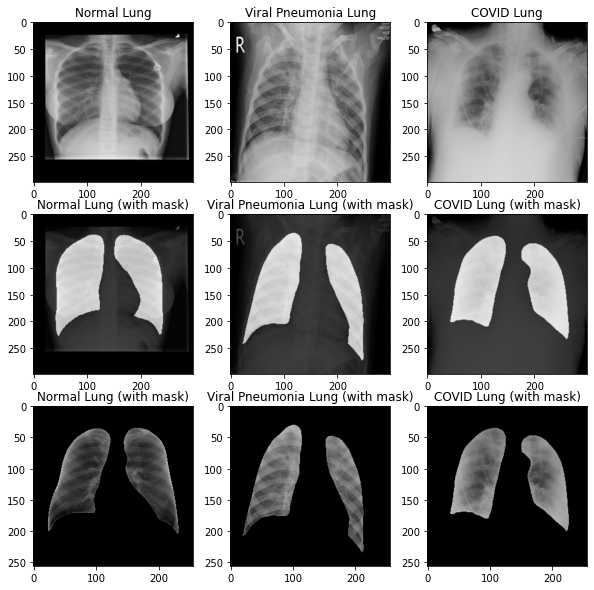

In [5]:
# create a 3 x 3 grid to display example images of each type
fig, axs = plt.subplots(3, 3, figsize=(10,10))

#No masks
axs[0][0].imshow(cv2.imread(f"{path}/Normal/images/Normal-1.png"))
axs[0][0].set_title('Normal Lung')
axs[0][1].set_title('Viral Pneumonia Lung')
axs[0][1].imshow(cv2.imread(f"{path}/Viral Pneumonia/images/Viral Pneumonia-1.png"))
axs[0][2].set_title('COVID Lung')
axs[0][2].imshow(cv2.imread(f"{path}/COVID/images/COVID-1.png"))

#Mask Overlay
axs[1][0].set_title('Normal Lung (with mask)')
axs[1][0].imshow(cv2.imread(f"{path}/Normal/images/Normal-1.png"))
axs[1][0].imshow(cv2.resize(cv2.imread(f"{path}/Normal/masks/Normal-1.png"), (299,299)), alpha=0.7)
axs[1][1].set_title('Viral Pneumonia Lung (with mask)')
axs[1][1].imshow(cv2.imread(f"{path}/Viral Pneumonia/images/Viral Pneumonia-1.png"))
axs[1][1].imshow(cv2.resize(cv2.imread(f"{path}/Viral Pneumonia/masks/Viral Pneumonia-1.png"), (299,299)), alpha=0.7)
axs[1][2].set_title('COVID Lung (with mask)')
axs[1][2].imshow(cv2.imread(f"{path}/COVID/images/COVID-1.png"))
axs[1][2].imshow(cv2.resize(cv2.imread(f"{path}/COVID/masks/COVID-1.png"), (299,299)), alpha=0.7)

#With Mask
axs[2][0].set_title('Normal Lung (with mask)')
axs[2][0].imshow(cv2.bitwise_and(cv2.resize(cv2.imread(f"{path}/Normal/images/Normal-10.png"), (256,256)), cv2.imread(f"{path}/Normal/masks/Normal-10.png")))
axs[2][1].set_title('Viral Pneumonia Lung (with mask)')
axs[2][1].imshow(cv2.bitwise_and(cv2.resize(cv2.imread(f"{path}/Viral Pneumonia/images/Viral Pneumonia-1.png"), (256,256)), cv2.imread(f"{path}/Viral Pneumonia/masks/Viral Pneumonia-1.png")))
axs[2][2].set_title('COVID Lung (with mask)')
axs[2][2].imshow(cv2.bitwise_and(cv2.resize(cv2.imread(f"{path}/COVID/images/COVID-1.png"), (256,256)), cv2.imread(f"{path}/COVID/masks/COVID-1.png")))

plt.show()

Above is how the data images look like. The first row are the original lung images. The second row are the lung images with the mask images on them. The third row are the lung images that with mask images applied and neglecting all the unnecessary part.

In [6]:
levels = ['Normal', 'COVID', 'Viral Pneumonia']

masked_images = {'Normal':[], 'COVID':[], 'Viral Pneumonia':[]}

for level in levels:
  for i in tqdm(range(1, 301)):
    masked_images[level].append(cv2.bitwise_and(cv2.resize(cv2.imread(f"{path}/"+level+"/images/"+level+"-"+str(i)+".png"), (256,256)), cv2.imread(f"{path}/"+level+"/masks/"+level+"-"+str(i)+".png")))


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 336.70it/s]


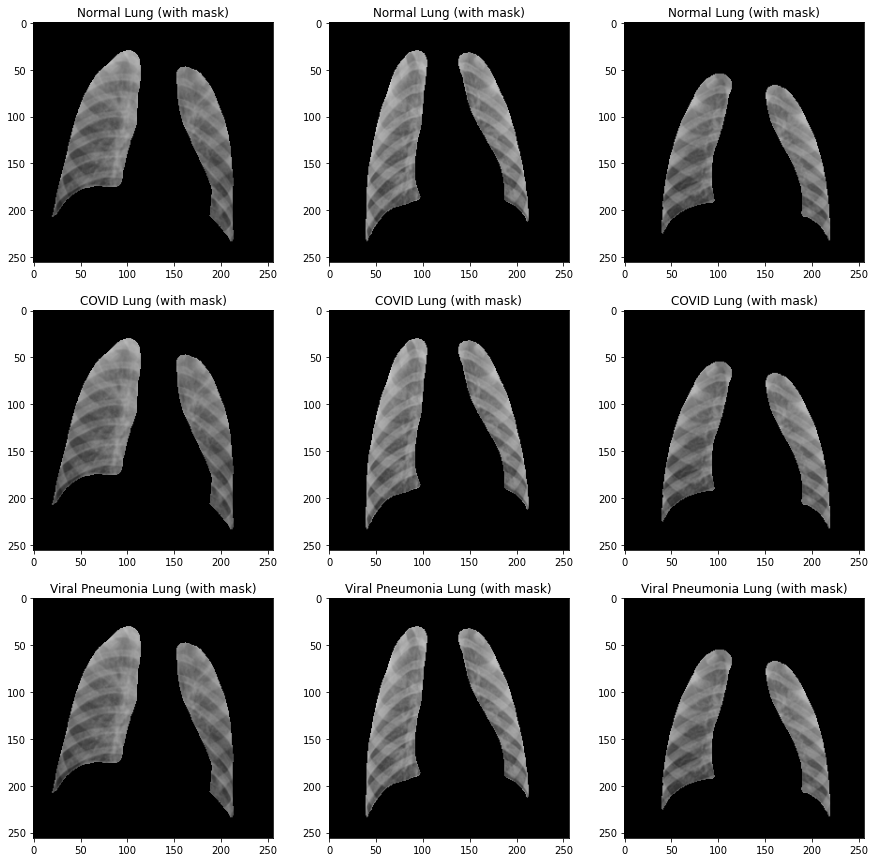

In [7]:
fig, axs = plt.subplots(3,3, figsize=(15,15))
for i in range(3):
  for j in range(3):
    axs[i][j].set_title(levels[i]+" Lung (with mask)")
    axs[i][j].imshow(masked_images[level][j])

# Proposed Solution

Our proposed solution would be implementing the algorithm of CNN to the dataset and then classify the images of lungs in the correct categories accordingly using the features extracted from the data. We will use the lung mask to crop out the images from the x-ray images. By cutting out the images we can reduce the amount of noise and allow the model to only focus on the areas which may contain elements of COVID-19. The model we are using is a Convolutional Neural Network, the CNN takes in an input image and uses weights and biases as well as various aspects in order to differentiate between each other. In the CNN the model there are multiple layers including the input, output, and hidden layer. The hidden layer consists of multiple convolutional layers, pooling layers, fully connected layers, and normalization layers. Some libraries we will use but are not limited to are the python libraries of keras and tensorflow. We want to use tensorflow in order to take advantage of its ability to utalize create complex neural networks and to run them effectively with its implementation of cuda cores. 

# Evaluation Metrics

By reducing our dataset into classes with equal quantities each we can assume a baseline 33% accuracy if we were to just use random assignment for our image dataset. This means that if our model is able to accurately distinguish the dataset above this 33% baseline we can assume that our model is somewhat successful. Other models that which use the same dataset have been found to have an accuracy over 95% and although we do not believe we will be able to reach such numbers, this does set us an upperbound for what we can expect to be achievable for the dataset. We will mark each image in the test dataset as correct if it able to correctly classify the image with its label and wrong if it fails to do so.

We will also look at the confusion matrix of the model to see how does our classification go. The confusion matrix can be used to evaluate the accuracy of the model. As to our project, the confusion matrix will have predicted classes of the lung images and the actual classes of the lung images. Therefore, the 2x2 matrix will have true positive, true negative, false positive and false negative as the rows and columns. We will calculate precision and recall to help us evaluating our model.

# Preliminary results

While the training of the CNN model and analysis will take an extensive amount of time and work before any results may come into fruition. What we can instead do is preform some preliminarily testing to see how our model may, in fact, interpret our data. We can do so by simply looking at the mean and standard deviation of the image samples. 


In [8]:
samples = 300
levels = ['Normal', 'COVID', 'Viral Pneumonia']
mean_val = {'Normal':[], 'COVID':[], 'Viral Pneumonia':[]}
std_dev_val = {'Normal':[], 'COVID':[], 'Viral Pneumonia':[]}

for level in levels:
  for i in range(samples):
      mean_val[level].append(masked_images[level][i].mean())
      std_dev_val[level].append(np.std(masked_images[level][i]))

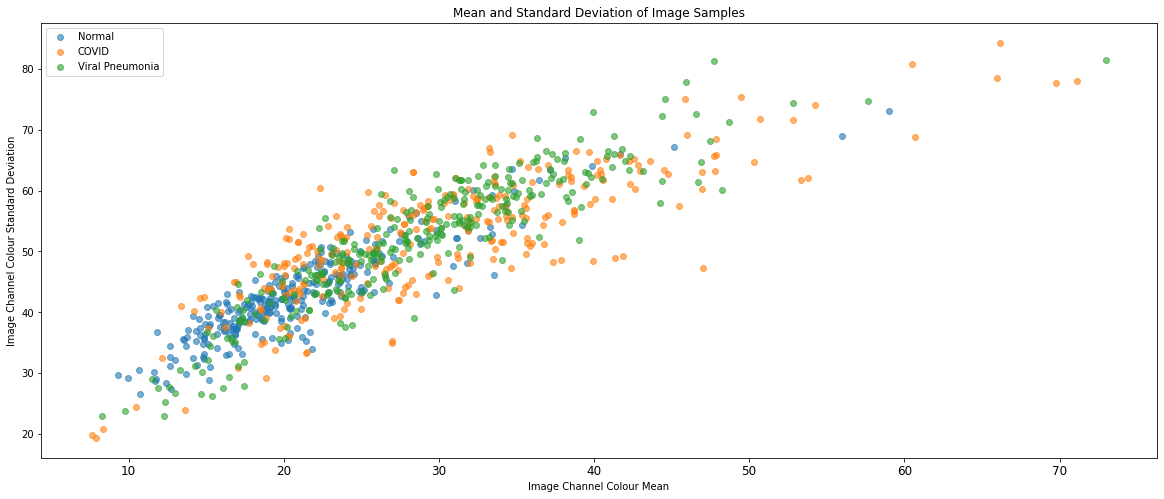

In [9]:
plt.figure(figsize=(20,8))
for level in levels:
  plt.scatter(mean_val[level], std_dev_val[level], label=level, alpha=0.6)
plt.title("Mean and Standard Deviation of Image Samples")
plt.legend(loc="upper left")
plt.xlabel("Image Channel Colour Mean")
plt.ylabel("Image Channel Colour Standard Deviation")
plt.xticks(rotation=0,fontsize = 12)
plt.show()

By looking at the mean and standard deviation of the image samples we can see some broad generalization of the data and see if, within the data there are any points of similarity. We first take a look at a scatter plot of all three levels plotted as different colors. Initial looks we can see that all the images follow a similar pattern with heavy concentrations on the middle of a right upwards line. We can assume that this central tendency is due impart from the masking of the dataset which removed a large part of noise from the images and leaving us with only the center part, aka the lungs.


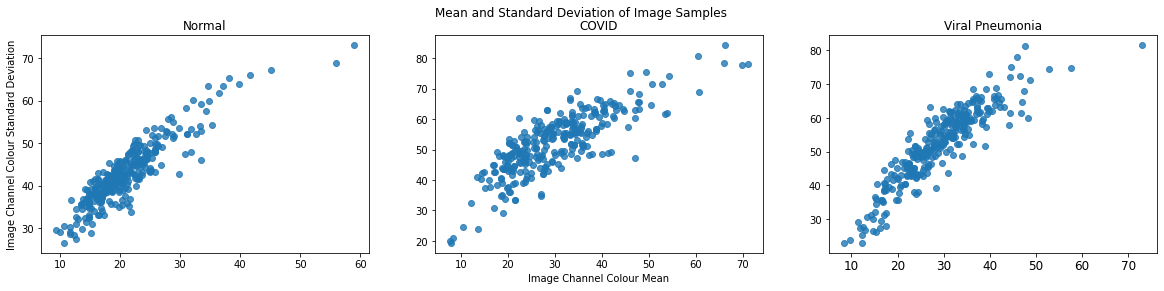

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(20,4))
for i in range(3):
  axs[i].scatter(mean_val[levels[i]], std_dev_val[levels[i]], alpha=0.8)
  axs[i].set_title(levels[i])

axs[1].set_xlabel("Image Channel Colour Mean")
axs[0].set_ylabel("Image Channel Colour Standard Deviation")
plt.xticks(rotation=0,fontsize = 12)
plt.suptitle("Mean and Standard Deviation of Image Samples")
plt.show()

Next we will plot each of the levels in their own separate plots and see if there are any differentiating characteristics between the three levels. Although initially there does not seem to be any similarities between the three levels, upon closer inspection we can see that we could see that while normal lungs have centralized in the lower left portion of the graph, COVID and viral pneumonia both have their centralized points towards the middle of the graph. What we can discern for these differences is that COVID and pneumonia both cause damage to the lung tissue which in turn would result in white marks on the scans (the white marks on the scan highlight damaged tissue areas). Whereas in normal lungs, the absence of damaged tissues would make it such that there are much more dark areas meaning the image would have lower mean and standard deviation scores. While to differentiate between COVID and pneumonia will still take more analysis, this new knowledge will help us when creating our machine learning model.

# Ethics & Privacy

This project is- at its base- an image classification project. While this specific project would help the efficiency in the medical field in terms of predictive diagnosis in respiratory illnesses and further research, the idea of image recognition in broader terms can be a topic that faces a lot of scrutiny. One of the main issues with image recognition are deepfakes. Deepfakes are essentially videos or images that takes a preexisting image/video and replaces the person in it with someone else's image/video. This can lead to a lot of misleading content as it can pass content that never existed as something genuine. For example, inserting a random person's face onto an incriminating video and passing it off as evidence for a crime and such. 

Anther issue that our project may come across specifically, is the privacy of the patients whose X-ray images come from. A patient's privacy is still extended in this case therefore, any electronic medical information must be secure. Theoretically, if this project is to be remade with original an dataset, the first step is to receive the patient's explicit consent in sharing the images and minor detail that is would be considered important to the research. Next is to remove names or anything that will be able to determine a patient's identity from the dataset.

# Team Expectations 

* Each group member shows up to meetings and stay updated on project progress
* Getting the assigned work done before next meeting so that project can be progressed
* Ask for help from each other or TAs/professor if assistance is needed
* Split up the work to make things easier to handle and such that everyone contributes to the project
* Respect each other
* Respond to the group messages

# Project Timeline Proposal

| Meeting Date  | Meeting Time| Completed Before Meeting  | Discuss at Meeting |
|---|---|---|---|
| 4/28  |  9 PM |  Brainstorm topics/questions (all)  | Discuss and decide on final project topic; discuss hypothesis; begin background research; PEER REVIEWS (DUE 4/29) | 
| 5/7  |  8 PM |  Do background research on topic; Dataset search and wrangling | Check ups: EDA, data processed, algorithms, etc. | 
| 5/12  | 9 PM  | Prep for checkpoint (as discussed in previous meeting)| More discuss over data wrangling and EDA |
| 5/18  | 8 PM  | EDA and data wrangling | Figure out the preliminary results section of the checkpoint |
| 5/19  | 8 PM  | Continue previous meeting | Continue and finish up the checkpoint  |
| 5/25  | 8 PM  | Model selection| Models results and comparison   |
| 5/28  | 8 PM  | Analysis | Analysis; Discuss/edit project code; Complete project |
| 6/04  | 8 PM  | Complete analysis; Draft results/conclusion/discussion (Carlos)| Discuss/edit full project |
| 6/08  | Before 11:59 PM  | NA | Turn in Final Project  |

# Footnotes
<a name="DluQwengnote"></a>1.[^](#DluQweng): D.Lu, Q.Weng Review Article a Survey of Image- Tandfonline.com. https://www.tandfonline.com/doi/pdf/10.1080/01431160600746456. <br> 
<a name="Alzubaidinote"></a>2.[^](#Alzubaidi): Alzubaidi, L., Zhang, J., Humaidi, A.J. et al. Review of deep learning: concepts, CNN architectures, challenges, applications, future directions. J Big Data 8, 53 (2021). https://doi.org/10.1186/s40537-021-00444-8<br>